### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import itertools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import aux_functions_ml as f
from collections import Counter
import json

### Load data

In [2]:
df_products = pd.read_csv("../Datasets/clean_products.csv", index_col = 0)
df_orders = pd.read_csv("../Datasets/clean_orders.csv", index_col = 0)
df_orders_details = pd.read_csv("../Datasets/clean_order_details.csv", index_col = 0)


Merge data

In [3]:
df = df_products.merge(df_orders_details, on = 'ProductID')
df = df.merge(df_orders, on = 'OrderID')
df

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,42.5,18,2,1,2003-08-11,2003-08-11,0.0,0,2003,8
1,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,2,1,2003-12-10,2003-12-10,0.0,0,2003,12
2,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,17.8,42,2,1,2003-12-08,2003-12-08,20.0,0,2003,12
3,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,2,1,2003-12-19,2003-12-19,0.0,0,2003,12
4,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,7,1,2004-01-14,2004-01-14,0.0,0,2004,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105051,4419,L-BX46CK,BX,Boxers,Men's Briefs,Underwear,90,L,Single Unit,In Production,...,19.0,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4
105052,4420,M-BX46CK,BX,Boxers,Men's Briefs,Underwear,85,M,Single Unit,In Production,...,18.0,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4
105053,4421,XL-BX46CK,BX,Boxers,Men's Briefs,Underwear,100,XL,Single Unit,In Production,...,21.0,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4
105054,4422,L-D46D,D,Briefs,Women's Panties,Underwear,285,L,Dozen,In Production,...,26.5,84,14,1,2006-04-07,2006-04-07,0.0,0,2006,4


In [4]:
df.groupby(['Category'])['QuantitySold'].sum().reset_index().sort_values(by='QuantitySold', ascending=False)

,Category,QuantitySold
1,Briefs,546494
0,Boxers,43153
7,Undershirts,35793
6,Thongs,32163
3,Drawers,16102
4,Regular-Over the Calf,3168
5,Slips,2300
2,Cuff-Over the Calf,39


In [5]:
df['ProductID'].nunique()

4029

In [6]:
total_products = df['ProductID'].nunique()
print(total_products)
products_per_slot = 1
required_slots = np.ceil(total_products / products_per_slot)
print(f" We need {int(required_slots)} slots.")

4029
 We need 4029 slots.


In [7]:
category_counts = df.groupby(['Category'])['ProductID'].nunique()
category_counts

Category
Boxers                    255
Briefs                   2769
Cuff-Over the Calf          3
Drawers                    44
Regular-Over the Calf      69
Slips                      61
Thongs                    473
Undershirts               355
Name: ProductID, dtype: int64

In [8]:
category_perc = (category_counts / category_counts.sum()) * 100
category_perc

Category
Boxers                    6.329114
Briefs                   68.726731
Cuff-Over the Calf        0.074460
Drawers                   1.092082
Regular-Over the Calf     1.712584
Slips                     1.514023
Thongs                   11.739886
Undershirts               8.811119
Name: ProductID, dtype: float64

In [9]:
result = pd.DataFrame({'Count': category_counts, 'Percentage': category_perc})
result.sort_values(by='Count', ascending = False)

,Count,Percentage
Category,,
Briefs,2769,68.726731
Thongs,473,11.739886
Undershirts,355,8.811119
Boxers,255,6.329114
Regular-Over the Calf,69,1.712584
Slips,61,1.514023
Drawers,44,1.092082
Cuff-Over the Calf,3,0.074460


#### Define warehouse dimension


In [10]:
required_slots

np.float64(4029.0)

In [11]:
rows = 70

cols = np.ceil(required_slots/rows)

rows, cols

(70, np.float64(58.0))

In [12]:
category_perc.items()

In [13]:
category_slots = {cat: int((pct/100)*required_slots) for cat, pct in category_perc.items()}
category_slots

{'Boxers': 255,
 'Briefs': 2769,
 'Cuff-Over the Calf': 3,
 'Drawers': 44,
 'Regular-Over the Calf': 69,
 'Slips': 61,
 'Thongs': 473,
 'Undershirts': 355}

## Study with knn the simililarities between categories

In [14]:
df_products

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,2003-07-10,6.6,182
1,2,3-183,AT,Undershirts,Girls' Undershirts,Underwear,620,M,Dozen,Out of Production,2003-07-10,5.6,183
2,3,3-184,AT,Undershirts,Girls' Undershirts,Underwear,718,M,Dozen,In Production,2003-07-10,6.3,184
3,4,3-185,AT,Undershirts,Boys' Undershirts,Underwear,820,M,Dozen,In Production,2003-07-10,5.6,185
4,5,3-A30N,A,Briefs,Girls' Panties,Underwear,214,M,Dozen,Out of Production,2003-08-06,3.3,A30N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,4419,L-BX46CK,BX,Boxers,Men's Briefs,Underwear,90,L,Single Unit,In Production,2006-04-04,1.3,BX46CK
4179,4420,M-BX46CK,BX,Boxers,Men's Briefs,Underwear,85,M,Single Unit,In Production,2006-04-04,1.2,BX46CK
4180,4421,XL-BX46CK,BX,Boxers,Men's Briefs,Underwear,100,XL,Single Unit,In Production,2006-04-04,1.4,BX46CK
4181,4422,L-D46D,D,Briefs,Women's Panties,Underwear,285,L,Dozen,In Production,2006-04-04,3.9,D46D


In [15]:
df_products.dtypes

ProductID             int64
ProductName          object
ModelDescription     object
Category             object
Gender               object
ProductLine          object
Weight                int64
Size                 object
PackSize             object
Status               object
InventoryDate        object
PurchasePrice       float64
ProductType          object
dtype: object

In [16]:
category_features = df_products.groupby(['Category']).agg({
    "ProductID":"count", #numero de productos
    "Weight": "mean", #peso promedio
    "Size": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan, #tamaño mas comun
    "PurchasePrice": "mean",  #precio promedio
    "Gender": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan, 
    "PackSize": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()
category_features

,Category,ProductID,Weight,Size,PurchasePrice,Gender,PackSize
0,Boxers,294,75.615646,M,1.177109,Men's Briefs,Single Unit
1,Briefs,2822,378.148831,M,4.827236,Women's Panties,Dozen
2,Cuff-Over the Calf,3,1000.000000,35-40,5.900000,Women's Socks,Dozen
3,Drawers,45,1115.133333,3XL,7.557111,Women's Panties,Dozen
4,Regular-Over the Calf,72,615.625000,40-46,4.473611,Children's Socks,Dozen
5,Slips,73,66.589041,L,0.655479,Men's Briefs,Single Unit
6,Thongs,497,171.225352,S,3.868310,Women's Panties,Dozen
7,Undershirts,362,673.196133,M,5.841713,Women's Undershirts,Dozen


In [17]:
category_features.rename(columns={
    "ProductID":"ProductCount", 
    "Weight": "AvgWeight", 
    "Size": "CommonSize", 
    "PurchasePrice": "AvgPrice", 
    "Gender": "CommonGender", 
    "PackSize": "CommonPackSize"
}, inplace=True)

category_features

,Category,ProductCount,AvgWeight,CommonSize,AvgPrice,CommonGender,CommonPackSize
0,Boxers,294,75.615646,M,1.177109,Men's Briefs,Single Unit
1,Briefs,2822,378.148831,M,4.827236,Women's Panties,Dozen
2,Cuff-Over the Calf,3,1000.000000,35-40,5.900000,Women's Socks,Dozen
3,Drawers,45,1115.133333,3XL,7.557111,Women's Panties,Dozen
4,Regular-Over the Calf,72,615.625000,40-46,4.473611,Children's Socks,Dozen
5,Slips,73,66.589041,L,0.655479,Men's Briefs,Single Unit
6,Thongs,497,171.225352,S,3.868310,Women's Panties,Dozen
7,Undershirts,362,673.196133,M,5.841713,Women's Undershirts,Dozen


In [18]:
#Convert categorical data to numerical data with label encoding

label_encoders = {}
for col in ["CommonSize", "CommonGender", "CommonPackSize"]:
    
    le = LabelEncoder()
    category_features[col] = le.fit_transform(category_features[col])
    label_encoders[col] = le
    

scaler = StandardScaler()
df_scaled = scaler.fit_transform(category_features.drop(columns=['Category']))

df_scaled
    

array([[-0.25642778, -1.14510722,  0.69644091, -1.40742974, -0.75047877,
         1.73205081],
       [ 2.59929653, -0.35112997,  0.69644091,  0.24418891,  0.10721125,
        -0.57735027],
       [-0.58515237,  1.28087507, -1.77979343,  0.72959584,  0.96490128,
        -0.57735027],
       [-0.53770758,  1.58303448, -1.16073485,  1.47940961,  0.10721125,
        -0.57735027],
       [-0.50720736,  0.27210968, -0.54167626,  0.08417983, -1.6081688 ,
        -0.57735027],
       [-0.50607772, -1.16879692,  0.07738232, -1.64345791, -0.75047877,
         1.73205081],
       [-0.02711131, -0.89418622,  1.3154995 , -0.18970839,  0.10721125,
        -0.57735027],
       [-0.17961241,  0.4232011 ,  0.69644091,  0.70322186,  1.82259131,
        -0.57735027]])

In [19]:
## apply knn to find similar categories

knn = NearestNeighbors(n_neighbors=3, metric="euclidean")
knn.fit(df_scaled)
distances, index = knn.kneighbors(df_scaled)

for i, category in enumerate(category_features['Category']):
    neighbors = [category_features['Category'][j] for j in index[i][1:]]
    print(f"Category {category} --> nearest neighbor {neighbors}")

Category Boxers --> nearest neighbor ['Slips', 'Thongs']
Category Briefs --> nearest neighbor ['Thongs', 'Undershirts']
Category Cuff-Over the Calf --> nearest neighbor ['Drawers', 'Undershirts']
Category Drawers --> nearest neighbor ['Cuff-Over the Calf', 'Regular-Over the Calf']
Category Regular-Over the Calf --> nearest neighbor ['Drawers', 'Thongs']
Category Slips --> nearest neighbor ['Boxers', 'Thongs']
Category Thongs --> nearest neighbor ['Undershirts', 'Briefs']
Category Undershirts --> nearest neighbor ['Thongs', 'Cuff-Over the Calf']


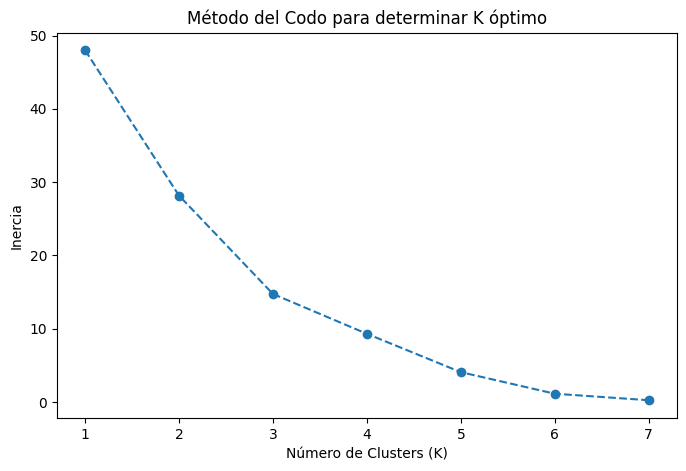

In [20]:
## apply kmeans to divide in cluster

# try with different values of k
inertia = []
K_range = range(1, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar K óptimo')
plt.show()



In [21]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
category_features["Cluster"] = kmeans.fit_predict(df_scaled)

# Ver los resultados
print(category_features[["Category", "Cluster"]])


                Category  Cluster
0                 Boxers        0
1                 Briefs        3
2     Cuff-Over the Calf        1
3                Drawers        1
4  Regular-Over the Calf        1
5                  Slips        0
6                 Thongs        2
7            Undershirts        2


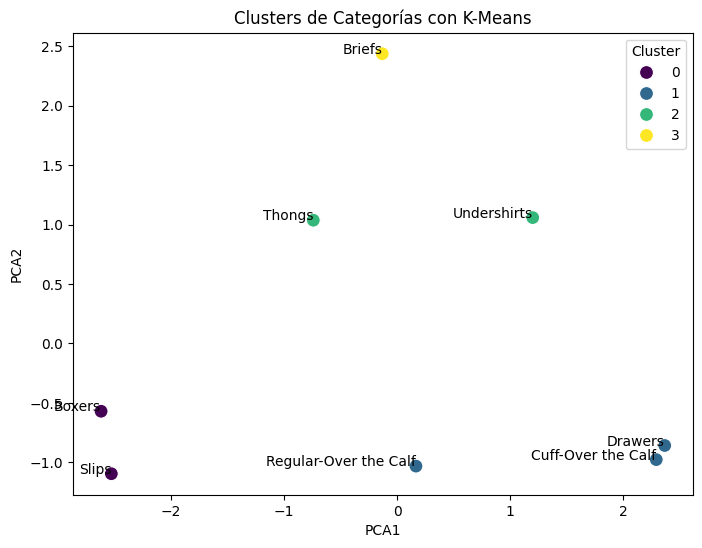

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

category_features["PCA1"] = df_pca[:, 0]
category_features["PCA2"] = df_pca[:, 1]

# Visualizar clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", data=category_features, palette="viridis", s=100)
for i, category in enumerate(category_features["Category"]):
    plt.text(category_features["PCA1"][i], category_features["PCA2"][i], category, fontsize=10, ha="right")
plt.title("Clusters de Categorías con K-Means")
plt.show()


PCA2 --> genero (negativo: masc y positivo: femenino)
PCA1 -->  cabtidad de tela (negativo: poca, positivo: mucha)

Distribution in the warehouse using cluster and knn

In [23]:
category_features

,Category,ProductCount,AvgWeight,CommonSize,AvgPrice,CommonGender,CommonPackSize,Cluster,PCA1,PCA2
0,Boxers,294,75.615646,4,1.177109,1,1,0,-2.617274,-0.570039
1,Briefs,2822,378.148831,4,4.827236,2,0,3,-0.132303,2.436823
2,Cuff-Over the Calf,3,1000.000000,0,5.900000,3,0,1,2.289750,-0.976738
3,Drawers,45,1115.133333,1,7.557111,2,0,1,2.364533,-0.858181
4,Regular-Over the Calf,72,615.625000,2,4.473611,0,0,1,0.165835,-1.031542
5,Slips,73,66.589041,3,0.655479,1,1,0,-2.526609,-1.095558
6,Thongs,497,171.225352,5,3.868310,2,0,2,-0.741602,1.036599
7,Undershirts,362,673.196133,4,5.841713,4,0,2,1.197670,1.058636


In [24]:
kmeans.labels_

array([0, 3, 1, 1, 1, 0, 2, 2], dtype=int32)

In [25]:
df_categories = pd.DataFrame({
    'Category': category_slots.keys(), 
    'Slots': category_slots.values(), 
    'Cluster': kmeans.labels_
})
df_categories = df_categories.sort_values(by='Cluster')
df_categories

,Category,Slots,Cluster
0,Boxers,255,0
5,Slips,61,0
3,Drawers,44,1
2,Cuff-Over the Calf,3,1
4,Regular-Over the Calf,69,1
6,Thongs,473,2
7,Undershirts,355,2
1,Briefs,2769,3


In [26]:
rows = int(rows)
cols = int(cols)

In [27]:
rows*cols, required_slots

(4060, np.float64(4029.0))

In [28]:
#definimos la malla
warehouse_map = np.zeros((rows, cols), dtype=object)

# asignamos las categorias en bloques de slots contiguos

row, col = 0, 0

for _, row_data in df_categories.iterrows():
    category, slots = row_data["Category"], row_data["Slots"]
    slots_filled = 0

    while slots_filled < slots:
        if col >= cols:  # Si llegamos al final de una fila, pasamos a la siguiente
            row += 1
            col = 0
        warehouse_map[row, col] = category
        slots_filled += 1
        col += 1

In [29]:
print(warehouse_map)

[['Boxers' 'Boxers' 'Boxers' ... 'Boxers' 'Boxers' 'Boxers']
 ['Boxers' 'Boxers' 'Boxers' ... 'Boxers' 'Boxers' 'Boxers']
 ['Boxers' 'Boxers' 'Boxers' ... 'Boxers' 'Boxers' 'Boxers']
 ...
 ['Briefs' 'Briefs' 'Briefs' ... 'Briefs' 'Briefs' 'Briefs']
 ['Briefs' 'Briefs' 'Briefs' ... 'Briefs' 'Briefs' 'Briefs']
 ['Briefs' 'Briefs' 'Briefs' ... 0 0 0]]


c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:330: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  category_to_color = {category: plt.cm.get_cmap("tab20")(i / len(unique_categories))[:3] if category != 0
c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:330: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  category_to_color = {category: plt.cm.get_cmap("tab20")(i / len(unique_categories))[:3] if category != 0
c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:330: MatplotlibDeprecationWarning: The ge

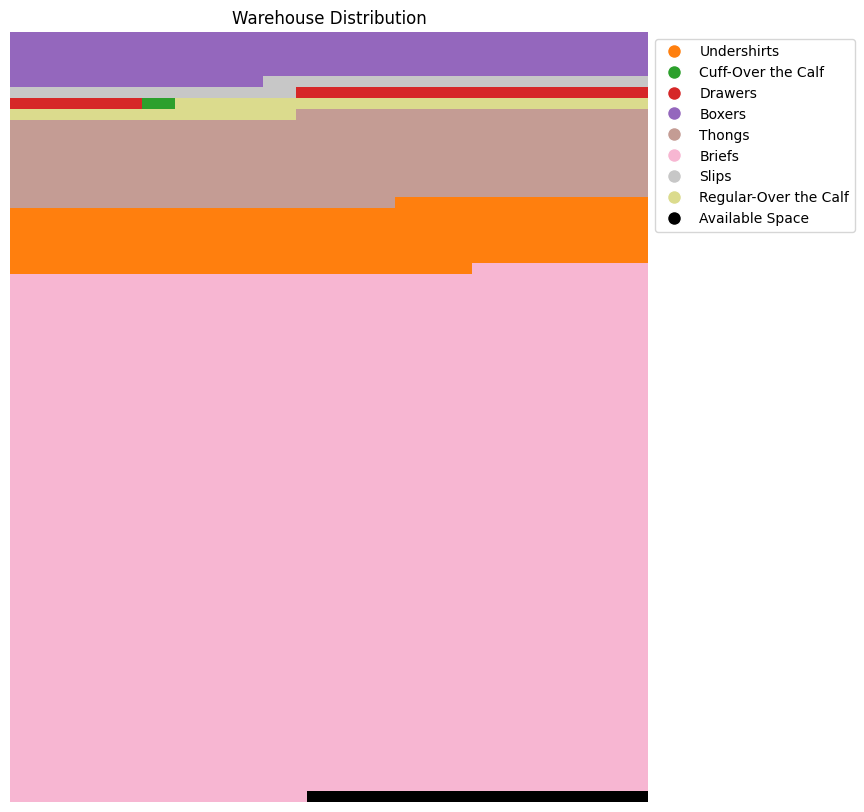

In [30]:
f.visualize_categories(warehouse_map, rows, cols)

In [31]:
category_percentages = f.calculate_category_percentages(warehouse_map)
category_percentages

{'Boxers': 6.280788177339902,
 'Slips': 1.5024630541871922,
 'Drawers': 1.083743842364532,
 'Cuff-Over the Calf': 0.07389162561576355,
 'Regular-Over the Calf': 1.6995073891625616,
 'Thongs': 11.650246305418719,
 'Undershirts': 8.74384236453202,
 'Briefs': 68.20197044334975,
 0: 0.7635467980295567}

### **Classification in the warehouse** (from to easier to pick up to more difficult):

1. Briefs
2. Boxers
3. Undershirts
4. Thongs
5. Drawers 
6. Regular-Over the Calf
7. Slips 
8. Cuff-Over the Calf


#### Separate datasets into categories

In [32]:
df['Category'].unique()

array(['Undershirts', 'Briefs', 'Boxers', 'Thongs', 'Slips', 'Drawers',
       'Regular-Over the Calf', 'Cuff-Over the Calf'], dtype=object)

In [33]:
df_briefs = df[df['Category'] == 'Briefs']
df_boxers = df[df['Category'] == 'Boxers']
df_undershirts = df[df['Category'] == 'Undershirts']
df_thongs = df[df['Category'] == 'Thongs']
df_drawers = df[df['Category'] == 'Drawers']
df_regular_over_calf = df[df['Category'] == 'Regular-Over the Calf']
df_slips = df[df['Category'] == 'Slips']
df_cuff_over_calf = df[df['Category'] == 'Cuff-Over the Calf']

### Analise similiraties between products into categories

### 1. Briefs

In [34]:
df_briefs['ProductName'].nunique() #2769 products 

2769

In [35]:
rules_briefs =f.similar_products(df_briefs, min_support=0.02)
rules_briefs

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(5), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(30), np.int64(32), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(50), np.int64(51), np.int64(53), np.int64(55), np.int64(59), np.int64(63), np.int64(71), np.int64(73), np.int64(76), np.int64(77), np.int64(78), np.int64(79), np.int64(84), np.int64(86), np.int64(89), np.int64(90), np.int64(139), np.int64(140), np.int64(141), np.int64(142), np.int64(143), np.int64(144), np.int64(145), np.int64(146), np.int64(147), np.int64(148), np.int64(149), np.int64(150), np.int64(165), np.int64(166), np.int64(167), np.int64(168), np.int64(169), np.int64(170), np.int64(171), np.int64(172), np.int64(173), np.int64(174), np.int64(175), np.int64(176), np.int64(177), 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(9),(17),0.179512,0.075634,0.028722,0.160000,2.115443,1.0,0.015145,1.100435,0.642649,0.126850,0.091269,0.269873
1,(17),(9),0.075634,0.179512,0.028722,0.379747,2.115443,1.0,0.015145,1.322828,0.570430,0.126850,0.244044,0.269873
2,(9),(25),0.179512,0.083772,0.030158,0.168000,2.005440,1.0,0.015120,1.101235,0.611046,0.129363,0.091929,0.264000
3,(25),(9),0.083772,0.179512,0.030158,0.360000,2.005440,1.0,0.015120,1.282013,0.547196,0.129363,0.219977,0.264000
4,(9),(28),0.179512,0.069411,0.025371,0.141333,2.036175,1.0,0.012911,1.083760,0.620220,0.113490,0.077287,0.253425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93400,(945),"(995, 996, 944, 1010, 1011, 989)",0.150790,0.022499,0.021063,0.139683,6.208443,1.0,0.017670,1.136210,0.987893,0.138365,0.119881,0.537926
93401,(1010),"(995, 996, 944, 945, 1011, 989)",0.131163,0.022978,0.021063,0.160584,6.988747,1.0,0.018049,1.163931,0.986276,0.158273,0.140843,0.538625
93402,(1011),"(995, 996, 944, 945, 1010, 989)",0.131163,0.024414,0.021063,0.160584,6.577644,1.0,0.017861,1.162220,0.975983,0.156584,0.139578,0.511665
93403,(989),"(995, 996, 944, 945, 1010, 1011)",0.168502,0.026328,0.021063,0.125000,4.747727,1.0,0.016626,1.112768,0.949338,0.121212,0.101340,0.462500


### 2. Boxers

In [36]:
df_boxers

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
437,6,3-BX34,BX,Boxers,Boys' Briefs,Underwear,55,M,Single Unit,Out of Production,...,24.0,13,1,1,2003-09-06,2003-09-06,0.0,0,2003,9
438,6,3-BX34,BX,Boxers,Boys' Briefs,Underwear,55,M,Single Unit,Out of Production,...,16.5,28,1,1,2003-09-11,2003-09-11,0.0,0,2003,9
439,6,3-BX34,BX,Boxers,Boys' Briefs,Underwear,55,M,Single Unit,Out of Production,...,4.4,29,2,1,2003-09-23,2003-09-23,0.0,0,2003,9
440,6,3-BX34,BX,Boxers,Boys' Briefs,Underwear,55,M,Single Unit,Out of Production,...,7.2,32,2,1,2003-09-27,2003-09-27,0.0,0,2003,9
441,6,3-BX34,BX,Boxers,Boys' Briefs,Underwear,55,M,Single Unit,Out of Production,...,0.8,5,2,1,2003-10-09,2003-10-09,0.0,0,2003,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105032,4391,M-BX4685SA,BX,Boxers,Men's Briefs,Underwear,80,M,Single Unit,In Production,...,84.8,231,14,1,2006-04-01,2006-04-01,0.0,0,2006,4
105050,4418,M-BX4668SA,BX,Boxers,Men's Briefs,Underwear,70,M,Single Unit,In Production,...,91.2,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4
105051,4419,L-BX46CK,BX,Boxers,Men's Briefs,Underwear,90,L,Single Unit,In Production,...,19.0,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4
105052,4420,M-BX46CK,BX,Boxers,Men's Briefs,Underwear,85,M,Single Unit,In Production,...,18.0,231,8,1,2006-04-20,2006-04-20,0.0,0,2006,4


In [37]:
df_boxers['ProductID'].nunique() #255 products

255

In [38]:
rules_boxers = f.similar_products(df_boxers, min_support=0.01)
rules_boxers

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(3614), np.int64(3616), np.int64(3617), np.int64(3618), np.int64(4140), np.int64(4141), np.int64(4142), np.int64(4143), np.int64(4144), np.int64(4145), np.int64(4146), np.int64(4147), np.int64(4148), np.int64(4149), np.int64(4150), np.int64(1079), np.int64(4151), np.int64(4152), np.int64(4153), np.int64(4154), np.int64(4155), np.int64(4156), np.int64(4157), np.int64(4158), np.int64(4159), np.int64(4160), np.int64(4161), np.int64(4162), np.int64(4163), np.int64(4164), np.int64(4165), np.int64(4166), np.int64(4167), np.int64(4178), np.int64(4180), np.int64(4181), np.int64(4182), np.int64(4187), np.int64(4188), np.int64(4190), np.int64(2142), np.int64(1119), np.int64(2143), np.int64(4193), np.int64(4194), np.int64(4195), np.int64(3172), np.int64(3173), np.int64(3174), np.int64(3175), np.int64(3176), np.int64(3177), np.int64(4197), np.int64(4198), np.int64(4209), np.int64(4210), np.int64(4243), np.int64(153), np.int64(154), np.int64(668), np.i

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(68),(6),0.075646,0.062731,0.044280,0.585366,9.331420,1.0,0.039535,2.260473,0.965902,0.470588,0.557615,0.645624
1,(6),(68),0.062731,0.075646,0.044280,0.705882,9.331420,1.0,0.039535,3.142804,0.952592,0.470588,0.681813,0.645624
2,(69),(6),0.095941,0.062731,0.023985,0.250000,3.985294,1.0,0.017967,1.249692,0.828571,0.178082,0.199803,0.316176
3,(6),(69),0.062731,0.095941,0.023985,0.382353,3.985294,1.0,0.017967,1.463715,0.799213,0.178082,0.316807,0.316176
4,(384),(6),0.049815,0.062731,0.011070,0.222222,3.542484,1.0,0.007945,1.205061,0.755340,0.109091,0.170166,0.199346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,(378),"(385, 788, 155, 797, 159)",0.086716,0.012915,0.011070,0.127660,9.884498,1.0,0.009950,1.131536,0.984175,0.125000,0.116246,0.492401
9167,(155),"(385, 788, 378, 797, 159)",0.321033,0.014760,0.011070,0.034483,2.336207,1.0,0.006332,1.020427,0.842391,0.034091,0.020018,0.392241
9168,(797),"(385, 788, 378, 155, 159)",0.090406,0.011070,0.011070,0.122449,11.061224,1.0,0.010069,1.126920,1.000000,0.122449,0.112626,0.561224
9169,(159),"(385, 788, 378, 155, 797)",0.090406,0.011070,0.011070,0.122449,11.061224,1.0,0.010069,1.126920,1.000000,0.122449,0.112626,0.561224


### 3. Undershirts

In [39]:
df_undershirts

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,42.5,18,2,1,2003-08-11,2003-08-11,0.0,0,2003,8
1,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,2,1,2003-12-10,2003-12-10,0.0,0,2003,12
2,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,17.8,42,2,1,2003-12-08,2003-12-08,20.0,0,2003,12
3,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,2,1,2003-12-19,2003-12-19,0.0,0,2003,12
4,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,...,0.0,40,7,1,2004-01-14,2004-01-14,0.0,0,2004,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104928,4328,LXL-ATL90,ATL,Undershirts,Women's Undershirts,Underwear,685,L-XL,Dozen,In Production,...,13.8,152,8,1,2006-03-22,2006-03-22,31.0,0,2006,3
104929,4328,LXL-ATL90,ATL,Undershirts,Women's Undershirts,Underwear,685,L-XL,Dozen,In Production,...,13.8,246,14,1,2006-04-01,2006-04-01,31.0,0,2006,4
104930,4328,LXL-ATL90,ATL,Undershirts,Women's Undershirts,Underwear,685,L-XL,Dozen,In Production,...,11.2,219,14,1,2006-03-30,2006-03-30,0.0,0,2006,3
104931,4328,LXL-ATL90,ATL,Undershirts,Women's Undershirts,Underwear,685,L-XL,Dozen,In Production,...,56.0,64,8,1,2006-04-01,2006-04-01,31.0,0,2006,4


In [40]:
df_undershirts['ProductID'].nunique()

355

In [41]:
rules_undershirts = f.similar_products(df_undershirts, min_support=0.015)
rules_undershirts

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(1032), np.int64(3101), np.int64(3102), np.int64(3109), np.int64(46), np.int64(64), np.int64(3138), np.int64(3139), np.int64(2118), np.int64(4168), np.int64(4169), np.int64(4170), np.int64(3140), np.int64(4172), np.int64(4173), np.int64(4174), np.int64(4175), np.int64(3143), np.int64(3148), np.int64(3166), np.int64(103), np.int64(4199), np.int64(4200), np.int64(109), np.int64(2160), np.int64(113), np.int64(2161), np.int64(2162), np.int64(2163), np.int64(119), np.int64(121), np.int64(122), np.int64(123), np.int64(124), np.int64(125), np.int64(126), np.int64(127), np.int64(128), np.int64(129), np.int64(130), np.int64(131), np.int64(132), np.int64(134), np.int64(136), np.int64(137), np.int64(138), np.int64(2188), np.int64(2190), np.int64(2192), np.int64(3242), np.int64(3249), np.int64(1205), np.int64(1214), np.int64(2246), np.int64(2248), np.int64(3730), np.int64(3279), np.int64(3280), np.int64(3281), np.int64(3282), np.int64(4318), np.int64(

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(1),(2),0.056731,0.057692,0.018269,0.322034,5.581921,1.0,0.014996,1.389904,0.870218,0.190000,0.280526,0.319350
1,(2),(1),0.057692,0.056731,0.018269,0.316667,5.581921,1.0,0.014996,1.380394,0.871106,0.190000,0.275569,0.319350
2,(1),(3),0.056731,0.073077,0.021154,0.372881,5.102587,1.0,0.017008,1.478067,0.852377,0.194690,0.323440,0.331178
3,(3),(1),0.073077,0.056731,0.021154,0.289474,5.102587,1.0,0.017008,1.327564,0.867409,0.194690,0.246741,0.331178
4,(1),(4),0.056731,0.125000,0.018269,0.322034,2.576271,1.0,0.011178,1.290625,0.648640,0.111765,0.225182,0.234094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35696,(111),"(769, 327, 330, 766, 117, 892, 894)",0.220192,0.015385,0.015385,0.069869,4.541485,1.0,0.011997,1.058577,1.000000,0.069869,0.055336,0.534934
35697,(117),"(769, 327, 330, 766, 111, 892, 894)",0.144231,0.017308,0.015385,0.106667,6.162963,1.0,0.012888,1.100029,0.978933,0.105263,0.090933,0.497778
35698,(892),"(769, 327, 330, 766, 111, 117, 894)",0.177885,0.016346,0.015385,0.086486,5.290938,1.0,0.012477,1.076781,0.986477,0.086022,0.071306,0.513831
35699,(894),"(769, 327, 330, 766, 111, 117, 892)",0.141346,0.021154,0.015385,0.108844,5.145331,1.0,0.012395,1.098400,0.938270,0.104575,0.089585,0.418058


### 4. Thongs

In [42]:
df_thongs

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
17078,310,L-TA31,TA,Thongs,Women's Panties,Underwear,193,L,Dozen,Out of Production,...,19.0,60,2,1,2004-03-01,2004-03-01,28.5,0,2004,3
17079,310,L-TA31,TA,Thongs,Women's Panties,Underwear,193,L,Dozen,Out of Production,...,16.5,2,6,1,2004-03-02,2004-03-02,28.0,0,2004,3
17080,310,L-TA31,TA,Thongs,Women's Panties,Underwear,193,L,Dozen,Out of Production,...,33.0,2,6,1,2004-03-10,2004-03-10,0.0,0,2004,3
17081,310,L-TA31,TA,Thongs,Women's Panties,Underwear,193,L,Dozen,Out of Production,...,3.8,81,6,1,2004-03-19,2004-03-19,0.0,0,2004,3
17082,310,L-TA31,TA,Thongs,Women's Panties,Underwear,193,L,Dozen,Out of Production,...,18.6,14,6,1,2004-03-29,2004-03-29,0.0,0,2004,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105030,4389,L-TB4607,TB,Thongs,Women's Panties,Underwear,205,L,Dozen,In Production,...,108.0,231,14,1,2006-04-01,2006-04-01,0.0,0,2006,4
105031,4390,L-TB4607S,TB,Thongs,Women's Panties,Underwear,205,L,Dozen,In Production,...,64.8,231,14,1,2006-04-01,2006-04-01,0.0,0,2006,4
105035,4395,M-TB4607S,TB,Thongs,Women's Panties,Underwear,160,M,Dozen,Out of Production,...,23.0,24,1,1,2006-04-05,2006-04-05,31.0,0,2006,4
105049,4417,L-TB4667,TB,Thongs,Women's Panties,Underwear,185,L,Dozen,In Production,...,50.0,182,1,1,2006-04-13,2006-04-13,31.0,0,2006,4


In [43]:
df_thongs['ProductID'].nunique()

473

In [44]:
rules_thongs = f.similar_products(df_thongs, min_support=0.01)
rules_thongs

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(4096), np.int64(4097), np.int64(4098), np.int64(4099), np.int64(4100), np.int64(4101), np.int64(4102), np.int64(4103), np.int64(4104), np.int64(4105), np.int64(4106), np.int64(4107), np.int64(4108), np.int64(1731), np.int64(3087), np.int64(3090), np.int64(2584), np.int64(2585), np.int64(2586), np.int64(2587), np.int64(2588), np.int64(2589), np.int64(2590), np.int64(2591), np.int64(3098), np.int64(3099), np.int64(2594), np.int64(3100), np.int64(3104), np.int64(3105), np.int64(2598), np.int64(2599), np.int64(3108), np.int64(2601), np.int64(2602), np.int64(3113), np.int64(2604), np.int64(2605), np.int64(2606), np.int64(3114), np.int64(1582), np.int64(3875), np.int64(3876), np.int64(2612), np.int64(2613), np.int64(2615), np.int64(2621), np.int64(2622), np.int64(2624), np.int64(2625), np.int64(2626), np.int64(2628), np.int64(1605), np.int64(2632), np.int64(2634), np.int64(1611), np.int64(2638), np.int64(2639), np.int64(2640), np.int64(2641), n

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(310),(311),0.025260,0.014859,0.013373,0.529412,35.629412,1.0,0.012998,2.093425,0.997121,0.500000,0.522314,0.714706
1,(311),(310),0.014859,0.025260,0.013373,0.900000,35.629412,1.0,0.012998,9.747400,0.986593,0.500000,0.897409,0.714706
2,(312),(313),0.031204,0.050520,0.020802,0.666667,13.196078,1.0,0.019226,2.848440,0.953988,0.341463,0.648931,0.539216
3,(313),(312),0.050520,0.031204,0.020802,0.411765,13.196078,1.0,0.019226,1.646954,0.973396,0.341463,0.392818,0.539216
4,(312),(587),0.031204,0.035661,0.010401,0.333333,9.347222,1.0,0.009288,1.446508,0.921779,0.184211,0.308680,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4286,(2781),"(2756, 2765, 2782)",0.054978,0.011887,0.010401,0.189189,15.915541,1.0,0.009748,1.218673,0.991689,0.184211,0.179435,0.532095
4287,(2756),"(2765, 2781, 2782)",0.034175,0.014859,0.010401,0.304348,20.482609,1.0,0.009893,1.416140,0.984835,0.269231,0.293855,0.502174
4288,(2765),"(2756, 2781, 2782)",0.034175,0.013373,0.010401,0.304348,22.758454,1.0,0.009944,1.418276,0.989890,0.280000,0.294919,0.541063
4289,(2782),"(2765, 2756, 2781)",0.068351,0.011887,0.010401,0.152174,12.801630,1.0,0.009589,1.165467,0.989519,0.148936,0.141975,0.513587


### 5. Drawers

In [45]:
df_drawers

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
48338,954,XXL-PCL23,PCL,Drawers,Women's Panties,Underwear,940,XXL,Dozen,In Production,...,55.2,5,1,1,2003-07-14,2003-07-14,0.0,0,2003,7
48339,954,XXL-PCL23,PCL,Drawers,Women's Panties,Underwear,940,XXL,Dozen,In Production,...,103.5,5,1,1,2003-07-15,2003-07-15,0.0,0,2003,7
48340,954,XXL-PCL23,PCL,Drawers,Women's Panties,Underwear,940,XXL,Dozen,In Production,...,34.5,4,1,1,2003-07-21,2003-07-21,0.0,0,2003,7
48341,954,XXL-PCL23,PCL,Drawers,Women's Panties,Underwear,940,XXL,Dozen,In Production,...,220.8,5,1,1,2003-07-22,2003-07-22,0.0,0,2003,7
48342,954,XXL-PCL23,PCL,Drawers,Women's Panties,Underwear,940,XXL,Dozen,In Production,...,34.5,2,1,1,2003-09-16,2003-09-16,0.0,0,2003,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101821,3631,6XL-PCL29,PCL,Drawers,Women's Panties,Underwear,1580,6XL,Dozen,Out of Production,...,57.3,155,8,1,2006-03-24,2006-03-24,31.0,0,2006,3
101822,3631,6XL-PCL29,PCL,Drawers,Women's Panties,Underwear,1580,6XL,Dozen,Out of Production,...,19.1,221,14,1,2006-03-24,2006-03-24,0.0,0,2006,3
101823,3631,6XL-PCL29,PCL,Drawers,Women's Panties,Underwear,1580,6XL,Dozen,Out of Production,...,0.0,57,14,1,2006-03-27,2006-03-27,0.0,0,2006,3
101824,3631,6XL-PCL29,PCL,Drawers,Women's Panties,Underwear,1580,6XL,Dozen,Out of Production,...,95.5,34,8,1,2006-04-03,2006-04-03,0.0,0,2006,4


In [46]:
df_drawers['ProductID'].nunique()

44

In [47]:
rules_drawers = f.similar_products(df_drawers, min_support=0.01)
rules_drawers

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(2113), np.int64(964), np.int64(2344), np.int64(2699), np.int64(2700), np.int64(2283), np.int64(3630), np.int64(3631), np.int64(2284), np.int64(2672), np.int64(2707), np.int64(2650)}

Number of missing products: 12 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(954),(963),0.116708,0.093366,0.038084,0.326316,3.495014,1.0,0.027187,1.345785,0.808201,0.221429,0.256939,0.367105
1,(963),(954),0.093366,0.116708,0.038084,0.407895,3.495014,1.0,0.027187,1.491783,0.787394,0.221429,0.329661,0.367105
2,(956),(958),0.272727,0.273956,0.149877,0.549550,2.005979,1.0,0.075162,1.611818,0.689549,0.377709,0.379583,0.548317
3,(958),(956),0.273956,0.272727,0.149877,0.547085,2.005979,1.0,0.075162,1.605761,0.690716,0.377709,0.377242,0.548317
4,(2280),(957),0.045455,0.192875,0.022113,0.486486,2.522293,1.0,0.013346,1.571770,0.632275,0.102273,0.363775,0.300568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11046,(1175),"(960, 961, 962, 956, 958, 959)",0.211302,0.033170,0.014742,0.069767,2.103359,1.0,0.007733,1.039343,0.665109,0.064171,0.037853,0.257106
11047,(956),"(960, 961, 962, 1175, 958, 959)",0.272727,0.014742,0.014742,0.054054,3.666667,1.0,0.010721,1.041558,1.000000,0.054054,0.039900,0.527027
11048,(958),"(960, 961, 962, 1175, 956, 959)",0.273956,0.014742,0.014742,0.053812,3.650224,1.0,0.010703,1.041292,1.000000,0.053812,0.039654,0.526906
11049,(959),"(960, 961, 962, 1175, 956, 958)",0.285012,0.018428,0.014742,0.051724,2.806897,1.0,0.009490,1.035113,0.900344,0.051064,0.033922,0.425862


### 6. Regular Over the Calf

In [48]:
df_regular_over_calf

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
81957,2064,5-S1D105,SD,Regular-Over the Calf,Children's Socks,Socks,365,5,Dozen,In Production,...,73.0,112,6,1,2004-11-05,2004-11-05,31.0,0,2004,11
81958,2064,5-S1D105,SD,Regular-Over the Calf,Children's Socks,Socks,365,5,Dozen,In Production,...,73.0,42,6,1,2004-11-05,2004-11-05,31.0,0,2004,11
81959,2064,5-S1D105,SD,Regular-Over the Calf,Children's Socks,Socks,365,5,Dozen,In Production,...,24.0,84,6,1,2004-11-12,2004-11-12,0.0,0,2004,11
81960,2064,5-S1D105,SD,Regular-Over the Calf,Children's Socks,Socks,365,5,Dozen,In Production,...,0.0,41,6,1,2004-12-01,2004-12-01,31.0,0,2004,12
81961,2064,5-S1D105,SD,Regular-Over the Calf,Children's Socks,Socks,365,5,Dozen,In Production,...,37.8,167,6,1,2004-12-21,2004-12-21,0.0,0,2004,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102091,3650,13-S1D103,SD,Regular-Over the Calf,Children's Socks,Socks,725,13,Dozen,In Production,...,7.8,203,8,1,2005-12-01,2005-12-01,31.0,0,2005,12
102092,3650,13-S1D103,SD,Regular-Over the Calf,Children's Socks,Socks,725,13,Dozen,In Production,...,8.5,229,8,1,2005-12-10,2005-12-10,0.0,0,2005,12
102093,3651,3540-S1D103,SD,Regular-Over the Calf,Women's Socks,Socks,825,35-40,Dozen,In Production,...,17.6,218,14,1,2005-11-03,2005-11-03,0.0,0,2005,11
102094,3651,3540-S1D103,SD,Regular-Over the Calf,Women's Socks,Socks,825,35-40,Dozen,In Production,...,8.8,203,8,1,2005-12-01,2005-12-01,31.0,0,2005,12


In [49]:
df_regular_over_calf['ProductID'].nunique()

69

In [50]:
rules_over_calf = f.similar_products(df_regular_over_calf)
rules_over_calf

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(3584), np.int64(3587), np.int64(3588), np.int64(3589), np.int64(3590), np.int64(3591), np.int64(3594), np.int64(3595), np.int64(3597), np.int64(3598), np.int64(3600), np.int64(3601), np.int64(2067), np.int64(2349), np.int64(2352), np.int64(3632), np.int64(2355), np.int64(2356), np.int64(3649), np.int64(3650), np.int64(3651), np.int64(3565), np.int64(3567), np.int64(3569), np.int64(3570), np.int64(3571), np.int64(3573), np.int64(3576), np.int64(3577), np.int64(3579), np.int64(3580)}

Number of missing products: 31 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(2064),(2065),0.148148,0.246914,0.086420,0.583333,2.362500,1.0,0.049840,1.807407,0.677019,0.280000,0.446721,0.466667
1,(2065),(2064),0.246914,0.148148,0.086420,0.350000,2.362500,1.0,0.049840,1.310541,0.765808,0.280000,0.236957,0.466667
2,(2064),(2068),0.148148,0.086420,0.061728,0.416667,4.821429,1.0,0.048925,1.566138,0.930435,0.357143,0.361486,0.565476
3,(2068),(2064),0.086420,0.148148,0.061728,0.714286,4.821429,1.0,0.048925,2.981481,0.867568,0.357143,0.664596,0.565476
4,(2064),(2070),0.148148,0.271605,0.111111,0.750000,2.761364,1.0,0.070873,2.913580,0.748792,0.360000,0.656780,0.579545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55272,(2070),"(2080, 2085, 2086, 2087, 2069, 2074, 2076, 2079)",0.271605,0.061728,0.061728,0.227273,3.681818,1.0,0.044963,1.214234,1.000000,0.227273,0.176435,0.613636
55273,(2074),"(2080, 2085, 2086, 2087, 2069, 2070, 2076, 2079)",0.197531,0.061728,0.061728,0.312500,5.062500,1.0,0.049535,1.364759,1.000000,0.312500,0.267270,0.656250
55274,(2076),"(2080, 2085, 2086, 2087, 2069, 2070, 2074, 2079)",0.296296,0.061728,0.061728,0.208333,3.375000,1.0,0.043439,1.185185,1.000000,0.208333,0.156250,0.604167
55275,(2079),"(2080, 2085, 2086, 2087, 2069, 2070, 2074, 2076)",0.160494,0.061728,0.061728,0.384615,6.230769,1.0,0.051821,1.524691,1.000000,0.384615,0.344130,0.692308


### 7. Slips

In [51]:
df_slips

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
27066,583,M-SLP12,SLP,Slips,Men's Briefs,Underwear,139,M,Single Unit,Out of Production,...,1.4,45,2,1,2003-12-10,2003-12-10,0.0,0,2003,12
27067,583,M-SLP12,SLP,Slips,Men's Briefs,Underwear,139,M,Single Unit,Out of Production,...,3.6,25,6,1,2004-02-26,2004-02-26,0.0,0,2004,2
27068,583,M-SLP12,SLP,Slips,Men's Briefs,Underwear,139,M,Single Unit,Out of Production,...,2.1,71,6,1,2004-03-02,2004-03-02,0.0,0,2004,3
27069,583,M-SLP12,SLP,Slips,Men's Briefs,Underwear,139,M,Single Unit,Out of Production,...,2.1,82,8,1,2004-03-22,2004-03-22,0.0,0,2004,3
27070,583,M-SLP12,SLP,Slips,Men's Briefs,Underwear,139,M,Single Unit,Out of Production,...,5.4,32,6,1,2004-04-16,2004-04-16,0.0,0,2004,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104920,4326,L-SLP46CI,SLP,Slips,Men's Briefs,Underwear,55,L,Single Unit,In Production,...,10.0,219,14,1,2006-03-30,2006-03-30,0.0,0,2006,3
104933,4331,XL-SLP46CK,SLP,Slips,Men's Briefs,Underwear,65,XL,Single Unit,In Production,...,14.0,137,8,1,2006-04-06,2006-04-06,0.0,0,2006,4
104939,4333,M-SLP46SK,SLP,Slips,Men's Briefs,Underwear,50,M,Single Unit,In Production,...,12.0,137,8,1,2006-04-06,2006-04-06,0.0,0,2006,4
104940,4334,XL-SLP46SI,SLP,Slips,Men's Briefs,Underwear,60,XL,Single Unit,In Production,...,11.0,219,14,1,2006-03-30,2006-03-30,0.0,0,2006,3


In [52]:
df_slips['ProductID'].nunique()

61

In [53]:
rules_slips = f.similar_products(df_slips, min_support=0.02)
rules_slips

c:\Users\Carlota\OneDrive\Documentos\Bootcamp Data Analysis\final-proyect\ML\aux_functions_ml.py:273: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = df_encoded.applymap(lambda x: 1 if x> 0 else 0)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Productos no cubiertos en las reglas: {np.int64(4283), np.int64(4284), np.int64(4285), np.int64(4286), np.int64(4287), np.int64(4288), np.int64(4289), np.int64(4290), np.int64(4291), np.int64(4298), np.int64(4300), np.int64(4326), np.int64(2151), np.int64(4331), np.int64(4333), np.int64(4334), np.int64(4215), np.int64(4218), np.int64(4348)}

Number of missing products: 19 



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(885),(583),0.177778,0.166667,0.100000,0.562500,3.375000,1.0,0.070370,1.904762,0.855856,0.409091,0.475000,0.581250
1,(583),(885),0.166667,0.177778,0.100000,0.600000,3.375000,1.0,0.070370,2.055556,0.844444,0.409091,0.513514,0.581250
2,(1223),(583),0.177778,0.166667,0.111111,0.625000,3.750000,1.0,0.081481,2.222222,0.891892,0.476190,0.550000,0.645833
3,(583),(1223),0.166667,0.177778,0.111111,0.666667,3.750000,1.0,0.081481,2.466667,0.880000,0.476190,0.594595,0.645833
4,(2138),(583),0.055556,0.166667,0.022222,0.400000,2.400000,1.0,0.012963,1.388889,0.617647,0.111111,0.280000,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67722,(2713),"(2138, 1223, 583, 885, 2711, 2712, 2714, 2715,...",0.100000,0.022222,0.022222,0.222222,10.000000,1.0,0.020000,1.257143,1.000000,0.222222,0.204545,0.611111
67723,(2714),"(2138, 1223, 583, 885, 2711, 2712, 2713, 2715,...",0.100000,0.022222,0.022222,0.222222,10.000000,1.0,0.020000,1.257143,1.000000,0.222222,0.204545,0.611111
67724,(2715),"(2138, 1223, 583, 885, 2711, 2712, 2713, 2714,...",0.111111,0.022222,0.022222,0.200000,9.000000,1.0,0.019753,1.222222,1.000000,0.200000,0.181818,0.600000
67725,(2716),"(2138, 1223, 583, 885, 2711, 2712, 2713, 2714,...",0.077778,0.022222,0.022222,0.285714,12.857143,1.0,0.020494,1.368889,1.000000,0.285714,0.269481,0.642857


### 8. Cuff over calf

In [54]:
df_cuff_over_calf

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,...,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
82205,2082,3540-SK1D106,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,42.8,42,6,1,2004-11-05,2004-11-05,31.0,0,2004,11
82206,2083,3540-SK1D206,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,107.0,112,6,1,2004-11-05,2004-11-05,31.0,0,2004,11
82207,2083,3540-SK1D206,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,214.0,42,6,1,2004-11-05,2004-11-05,31.0,0,2004,11
82208,2084,3540-SK1D501,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,0.0,2,6,1,2004-11-06,2004-11-06,0.0,0,2004,11
82209,2084,3540-SK1D501,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,0.0,151,6,1,2004-11-10,2004-11-10,31.0,0,2004,11
82210,2084,3540-SK1D501,SKD,Cuff-Over the Calf,Women's Socks,Socks,1000,35-40,Dozen,In Production,...,44.0,84,6,1,2004-11-12,2004-11-12,0.0,0,2004,11


In [55]:
df_cuff_over_calf['ProductID'].nunique()

3

### Distribute products

In [56]:
rules_by_category = {
    'Briefs': rules_briefs,
    'Undershirts': rules_undershirts,
    'Boxers': rules_boxers,
    'Slips': rules_slips,
    'Drawers': rules_drawers,
    'Cuff-Over the Calf': [],  # No reglas de asociación para esta categoría, pq son muy pocos y ningun producto se ha vendido junto
    'Regular-Over the Calf': rules_over_calf,
    'Thongs': rules_thongs
}

In [57]:
products_by_category ={
    'Briefs': list(set(df_briefs['ProductID'].to_list())), 
    'Undershirts' : list(set(df_undershirts['ProductID'].to_list())), 
    'Boxers' : list(set(df_boxers['ProductID'].to_list())), 
    'Slips' : list(set(df_slips['ProductID'].to_list())), 
    'Drawers': list(set(df_drawers['ProductID'].to_list())), 
    'Cuff-Over the Calf': list(set(df_cuff_over_calf['ProductID'].to_list())), 
    'Regular-Over the Calf': list(set(df_regular_over_calf['ProductID'].to_list())), 
    'Thongs': list(set(df_thongs['ProductID'].to_list()))
}
products_by_category

{'Briefs': [5,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  71,
  72,
  73,
  74,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  229,
  230,
  231,
  232,
  233,
  234,
 

In [58]:
category_slots

{'Boxers': 255,
 'Briefs': 2769,
 'Cuff-Over the Calf': 3,
 'Drawers': 44,
 'Regular-Over the Calf': 69,
 'Slips': 61,
 'Thongs': 473,
 'Undershirts': 355}

In [59]:
df_categories

,Category,Slots,Cluster
0,Boxers,255,0
5,Slips,61,0
3,Drawers,44,1
2,Cuff-Over the Calf,3,1
4,Regular-Over the Calf,69,1
6,Thongs,473,2
7,Undershirts,355,2
1,Briefs,2769,3


In [60]:
category_slots

{'Boxers': 255,
 'Briefs': 2769,
 'Cuff-Over the Calf': 3,
 'Drawers': 44,
 'Regular-Over the Calf': 69,
 'Slips': 61,
 'Thongs': 473,
 'Undershirts': 355}

In [71]:
updated_warehouse_map, product_slots = f.distribute_products(
    warehouse_map, rows, cols, df_categories, rules_by_category, products_by_category, category_slots, df_products
)

In [72]:
updated_warehouse_map

array([[6, 7, 1034, ..., 1116, 1117, 1118],
       [1119, 1120, 2136, ..., 1209, 1210, 3260],
       [4190, 2252, 3291, ..., 1888, 1889, 1890],
       ...,
       [4054, 4055, 4056, ..., 4176, 4177, 4202],
       [4203, 4204, 4206, ..., 4357, 4358, 4359],
       [4360, 4361, 4363, ..., 0, 0, 0]], dtype=object)

In [73]:
product_slots

{}

In [64]:
len(product_slots.keys())

4029

In [74]:
df_products['ProductID'].nunique()

4168

In [75]:
warehouse_map

array([[6, 7, 1034, ..., 1116, 1117, 1118],
       [1119, 1120, 2136, ..., 1209, 1210, 3260],
       [4190, 2252, 3291, ..., 1888, 1889, 1890],
       ...,
       [4054, 4055, 4056, ..., 4176, 4177, 4202],
       [4203, 4204, 4206, ..., 4357, 4358, 4359],
       [4360, 4361, 4363, ..., 0, 0, 0]], dtype=object)

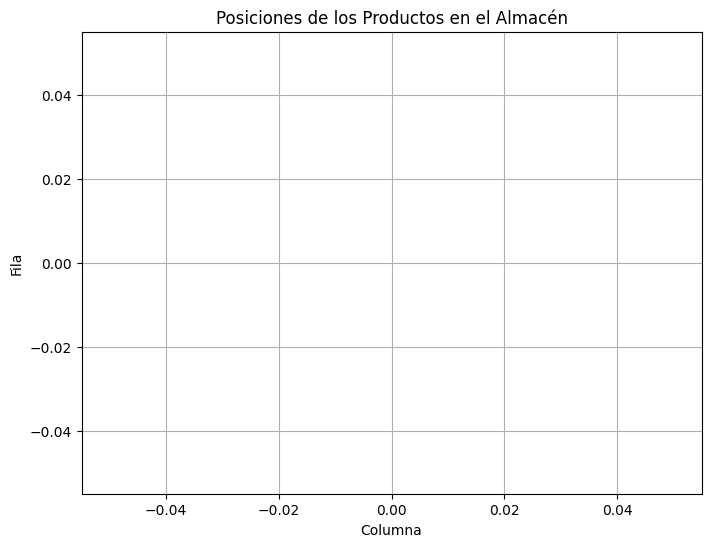

In [76]:

coordenadas = list(product_slots.values())
x = [pos[0] for pos in coordenadas]  # Fila
y = [pos[1] for pos in coordenadas]  # Columna
productos_ids = list(product_slots.keys())

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y, x, c='blue', label='Producto', marker='o')  # Fila vs Columna
plt.title("Posiciones de los Productos en el Almacén")
plt.xlabel("Columna")
plt.ylabel("Fila")

# Etiquetas para cada producto
for i, product_id in enumerate(productos_ids):
    plt.text(y[i], x[i], str(product_id), fontsize=12, ha='right')

plt.grid(True)
plt.show()


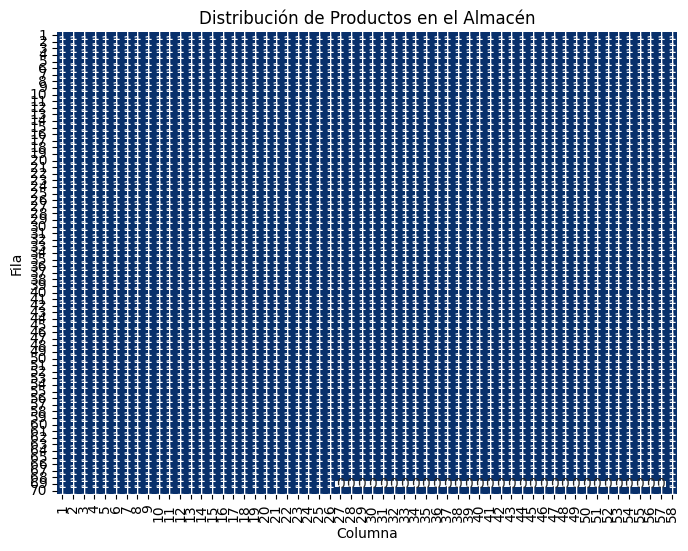

In [68]:
almacen = np.zeros((rows, cols))

for pos in product_slots.values():
    fila, columna = pos
    almacen[fila-1, columna-1] = 1  
    
almacen = almacen.astype(int)

# Crear el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(almacen, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(1, cols+1), yticklabels=range(1, rows+1))
plt.title("Distribución de Productos en el Almacén")
plt.xlabel("Columna")
plt.ylabel("Fila")
plt.show()


In [69]:
product_slots

{6: (0, 0),
 7: (0, 1),
 1034: (0, 2),
 3614: (0, 3),
 3615: (0, 4),
 3616: (0, 5),
 3617: (0, 6),
 3618: (0, 7),
 4180: (0, 8),
 4140: (0, 9),
 4141: (0, 10),
 4142: (0, 11),
 4143: (0, 12),
 4144: (0, 13),
 4145: (0, 14),
 4146: (0, 15),
 4147: (0, 16),
 4148: (0, 17),
 4149: (0, 18),
 1078: (0, 19),
 1079: (0, 20),
 1080: (0, 21),
 4150: (0, 22),
 4151: (0, 23),
 4152: (0, 24),
 4153: (0, 25),
 1597: (0, 26),
 4154: (0, 27),
 4155: (0, 28),
 4156: (0, 29),
 4157: (0, 30),
 2114: (0, 31),
 4158: (0, 32),
 68: (0, 33),
 69: (0, 34),
 4159: (0, 35),
 4160: (0, 36),
 4161: (0, 37),
 4162: (0, 38),
 4163: (0, 39),
 4164: (0, 40),
 4165: (0, 41),
 4166: (0, 42),
 4167: (0, 43),
 4187: (0, 44),
 4188: (0, 45),
 4178: (0, 46),
 1108: (0, 47),
 1109: (0, 48),
 1110: (0, 49),
 1111: (0, 50),
 1112: (0, 51),
 1113: (0, 52),
 1114: (0, 53),
 1115: (0, 54),
 1116: (0, 55),
 1117: (0, 56),
 1118: (0, 57),
 1119: (1, 0),
 1120: (1, 1),
 2136: (1, 2),
 2137: (1, 3),
 1635: (1, 4),
 2142: (1, 5),
 2

In [70]:
# Convertir las claves a 'int' si son 'int64'
product_slots = {int(k): v for k, v in product_slots.items()}

# Guardar el diccionario como un archivo JSON
with open("product_slot.json", "w") as file:
    json.dump(product_slots, file)

print("Archivo JSON guardado correctamente.")

Archivo JSON guardado correctamente.
